# Solving the Hamiltonian Cycle Problem

In this notebook, we'll explore how to tackle the **Hamiltonian Cycle problem** problem using LunaSolve. First, we'll introduce and explain the Hamiltonian Cycle problem through a straightforward example. Then, we'll walk step-by-step through modeling a real-world instance, optimizing the solution, and finally interpreting the results provided by LunaSolve.



## Table of Contents

1. [Introduction](#1)
2. [A Real World Example](#2)
3. [Solving the Hamiltonian Cycle problem with Luna](#3)



<a id="1"></a>
## 1. Introduction

## Hamiltonian Cycle problem

The Hamiltonian Cycle problem is a classic combinatorial optimization problem in computer science and graph theory. The problem involves determining if a given graph contains a Hamiltonian Cycle. A Hamiltonian Cycle is a route which visits every node of the graph exactly once and returns to the starting point. The possible paths which can be taken from each node are encoded by the edges connecting it to other nodes and can be directed or undirected, meaning that some paths between nodes might only be possible or more costly along a certain direction. When costs are associated with edges, the problem can become one of finding a Hamiltonian Cycle with minimal total cost which is also known as the Traveling Salesman Problem.

Formally this means that given a graph $ G = (V, E) $ with $ V = \{ v_1, v_2, \ldots, v_n \} $ as the set of vertices and $ E $ as the set of edges. A Hamiltonian Cycle in $ G $ is a sequence of vertices $(v_{p(1)}, v_{p(2)}, \ldots, v_{p(n)})$ (where $p(i)$ is the index of the vertex at the $i^{th}$ position)such that :

1. Each vertex in $ V $ appears exactly once in the sequence.

2. For all $ i = 1, \ldots, n-1 $, we have $(v_{p(i)}, v_{p(i+1)}) \in E$. Meaning that consecutive vertices must be connected by an edge.


<a id="2"></a>
## 2. A Real World Example

Consider this simplified scenario: A traveler wishes to plan an itinerary to visit multiple cities in a particular region. Due to limited flight availability, not all cities are directly connected by air, and the traveler can only move from one city to another if there is a flight route between them. The traveler’s goal is to determine if there exists an itinerary that allows visiting each city exactly once and then returning to the original departure city. There is no concern about flight costs or distances in this scenario—only the feasibility of such a route.

As an example, imagine we have five cities: A, B, C, D, and E. Because of limited flight routes, these cities are only sparsely connected. We can visualize this situation using a graph where each node represents a city and each edge indicates the existence of a flight connection between two cities. Some connections might be missing, which could prevent the traveler from finding a valid path that visits every city exactly once and returns to the starting point.

Vertices (Cities): U={A,B,C,D,E}
Edges (Possible Routes):
- (A, B)
- (A, C)
- (B, D)
- (C, D)
- (D, E)

<a id="3"></a>
## 3. Solving the  Hamiltonian Cycle problem with Luna

To follow along with the next steps, you'll need the following three libraries:
1. **luna_quantum** for modeling and solving our optimization problem,
2. **matplotlib** for visualizing the results, and
3. **networkx** for creating and displaying the graphs.

Run the cell below to install these libraries automatically if they aren't already installed.

In [ ]:
# Install the python packages that are needed for the notebook
%pip install --upgrade pip
%pip install luna_quantum --upgrade
%pip install matplotlib networkx

### 3.1 Setting Up the Luna Client

Now let's dive into solving the Hamiltonian Cycle problem using LunaSolve. First, you'll instantiate a LunaSolve object and configure your credentials. The API key identifies your account and grants access to Luna's services. You can find your API key in your Aqarios account settings.

In [2]:
from luna_quantum import LunaSolve
import getpass
import os

if "LUNA_API_KEY" not in os.environ:
    # Prompt securely for the key if not already set
    os.environ["LUNA_API_KEY"] = getpass.getpass("Enter your Luna API key: ")

ls = LunaSolve()

In [ ]:
from luna_quantum import Logging
import logging

Logging.set_level(logging.WARNING)

If you haven't yet configured a QPU token for your account, or if you'd like to add a new one, you can do so using the `ls.qpu_token.create()` method. However, in this tutorial we will be using a classical solver from Dwave, which does not require one.

### 3.2 Create a Hamiltonian Cycle problem

To create a `HamiltonianCycle` instance, any graph with vertices and edges is sufficient. In this notebook, we will create a graph representing the network of flight connections between 5 cities, labeled from "A"-"E".

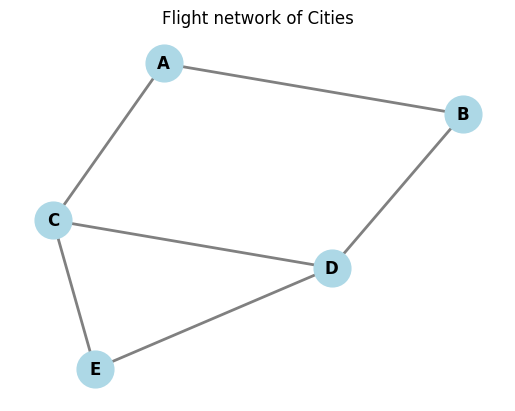

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

# Define the graph
hamiltonian_cycle_graph = nx.Graph()

# Define and add the nodes of the graph. Every node represnts a city of the example.
cities = ["A", "B", "C", "D", "E"]
hamiltonian_cycle_graph.add_nodes_from(cities)

# Define and add the edges of the graph. Each edge is an available connection between cities
edges = [
    ("A", "B"),
    ("A", "C"),
    ("B", "D"),
    ("C", "D"),
    ("D", "E"),
    ("E", "C")
]
hamiltonian_cycle_graph.add_edges_from(edges)

# Set all edges to the default color (this will be neded later for the visualization)
for edge in hamiltonian_cycle_graph.edges:
    hamiltonian_cycle_graph[edge[0]][edge[1]]['color'] = 'gray'

# Draw the graph
pos = nx.spring_layout(hamiltonian_cycle_graph, seed=42)
nx.draw_networkx_nodes(hamiltonian_cycle_graph, pos, node_color='lightblue', node_size=700)
nx.draw_networkx_labels(hamiltonian_cycle_graph, pos, font_size=12, font_weight='bold')
nx.draw_networkx_edges(hamiltonian_cycle_graph, pos, width=2, edge_color='gray')
plt.title("Flight network of Cities")
plt.axis('off')
plt.show()

### 3.3 Defining a Hamiltonian Cycle Object

The graph we've created represents a network of friendships. To identify the best way to partition this network, we'll define the Hamiltonian Cycle problem using LunaSolve's `HamiltonianCycle` class. This class transforms the friendship graph into an optimization problem, ready for LunaSolve to optimize.

When initializing the `HamiltonianCycle` object, ensure you pass the graph as a dictionary using NetworkX's `nx.to_dict_of_dicts()` method. Optionally, you can provide a descriptive `name` for your instance, if not specified, LunaSolve defaults it to `HC` for HamiltonianCycle.

In [5]:
# Import the HamiltonianCycle object from the luna sdk
from luna_quantum.solve.use_cases import HamiltonianCycle

# Create a HamiltonianCycle object, to use within the luna_sdk for optimisation
hamiltonian_cycle = HamiltonianCycle(graph=nx.to_dict_of_dicts(hamiltonian_cycle_graph))

### 3.4 Uploading the Use Case Model to Luna 

Now, let's upload our Hamiltonian Cycle problem to Luna. We can use LunaSolve's `ls.model.create_from_use_case()` method and provide the use case object we just defined and assign a clear, identifiable `name` to the optimization. 

In [6]:
# Create and upload a model using the created use case instance
model = ls.model.create_from_use_case(name="Hamiltonian Cycle", use_case=hamiltonian_cycle)

### 3.5 Choose an Algorithm and Run It

The final step is to create a job request, sending our optimization task to the hardware provider to solve. In order to succesfully create a job, we must first select an algorithm for the optimization from LunaSolve's collection, specify the algorithm's parameters and select a backend for the algorithm to run on.

In this instance, we solve the Hamiltonian Cycle problem using simulated annealing (sa) and choose D-Wave (dwave) as the hardware provider. Simulated annealing has multiple parameters which can be adjusted to fine-tune the exact optimization. Here we are going to set the `num_reads` equal to 1000. This means that the annealing process is done 1000 times, returning 1000 sampled results.

Lastly, we exectue the job by calling the `algorithm.run()` method and passing the `model` together with a chosen `name`for the job for easy identification. 

In [7]:
from luna_quantum.solve.parameters.algorithms import SimulatedAnnealing
from luna_quantum.solve.parameters.backends import DWave

#Select the SimulatedAnnealingSolver algorithm.
algorithm = SimulatedAnnealing(
    backend=DWave(),
    num_reads=1000, 
)

# Execute an outbound solve request.
job = algorithm.run(model.id, name="Hamiltonian Cycle with SA")

### 3.6 Retrieving the Solution

In step 3.4, we uploaded our problem, and in step 3.5, we sent a solution request to Luna. Luna automatically manages the subsequent background processes. This includes preparing the optimization problem, converting it into the correct format for the quantum hardware provider, submitting the problem to the quantum computer, and finally retrieving and translating the solution back into a user-friendly format.

Now let's discuss the final stages: retrieving the solution, converting it back to our original problem representation, and interpreting the results.

First, we'll use the `job.result()` method to fetch our results. The returned `Solution` object contains several attributes related to the optimization, including metadata such as the `runtime`, the `count` (how often each sample occurred), the `objective_value` and `raw_energies` of each sample. To learn more about the `Solution` Object visit Luna's thorough documentation.

In [ ]:
solution = job.result()

The `Solution`object returns the sampled solutions in the native optimization format of the provider's solver together with its metadata. To interpret the solutions quicker, LunaSolve provides automatic post-processing functions which decode the samples back into an intuitive and easy-to-read format as below.

You can use the `job.get_use_case_representation_result()` method to retrieve the decoded form of the solution. This returns the solution in a readable format, with a few key components:

- The `sense` attribute indicates whether our objective is to maximize or minimize the target function.
- The `result` is typically an iterable containing the `representation` (the solution itself) and the corresponding `obj_value` (objective value). While the objective value can be complex due to embedded constraint penalties, generally, smaller values signify better solutions for minimization problems and vice versa for maximization problems.
- The `description` helps clarify the format of the returned `representation`.

In the case of the Hamiltonian Cycle problem, the `representation` is implemented as a dictionary. This dictionary includes an `is_valid` key that indicates whether the given solution constitutes a valid Hamiltonian cycle. The subsequent keys correspond to the names of the nodes, listed in the order they appear along the solution path. Finally, the dictionary contains a `path` key, which holds the sequence of node indices—these indices follow the order defined in `hamiltonian_cycle_graph.nodes.values()` and represent the path taken by the solution.

****

### 🔍 Upcoming Feature: Use Case Representation Analysis

*Coming soon to the Luna SDK!*

We're introducing a powerful new capability: Use Case Representation Analysis. This feature will allow you to analyze and visualize how your use cases are interpreted across models and workflows—giving you deeper insight into solution quality, representation alignment, and more.

✨ **What to Expect**   
You'll soon be able to retrieve and examine the full use case representation for a given solve job:

In [ ]:
use_case_result = ls.solve_job.get_use_case_representation(job.id)
print(use_case_result)

Finally, if we wish to only see the best solution from all evaluated samples we can call the `job.get_use_case_representation_best_result()` method.

In [ ]:
best_use_case_result = ls.solve_job.get_best_use_case_result(use_case_result)
print(best_use_case_result)

To better grasp the solution, we can visualize again our graph, and colour all nodes that have a value of 0 red and all others that are 1 green.

In [ ]:
# Initialize all edges with a default color
for edge in hamiltonian_cycle_graph.edges:
    hamiltonian_cycle_graph[edge[0]][edge[1]]['color'] = 'gray'
    
# Color each edge included in the Hamiltonian cycle path
path = best_use_case_result["solution"]["path"]
for node_1, node_2 in zip(path[:-1], path[1:]):
    c_1, c_2 = cities[node_1], cities[node_2]
    hamiltonian_cycle_graph[c_1][c_2]['color'] = 'green'

# Draw the graph with the updated edge colors
edge_colors = [hamiltonian_cycle_graph[edge[0]][edge[1]]['color'] for edge in hamiltonian_cycle_graph.edges]
nx.draw_networkx_nodes(hamiltonian_cycle_graph, pos, node_color='lightblue', node_size=700)
nx.draw_networkx_labels(hamiltonian_cycle_graph, pos, font_size=12, font_weight='bold')
nx.draw_networkx_edges(hamiltonian_cycle_graph, pos, width=2, edge_color=edge_colors)
plt.title("Flight network of Cities")
plt.axis('off')
plt.show()

Congrats! You have now solved the Set Partitioning problem using the use case library of Luna! If you are interested in finding out more about the plethora of different use cases Luna provides, we encourage you to explore the use case library!